# ecallisto-fits Complete Tutorial

A comprehensive guide to the **ecallisto-fits** library for working with e-CALLISTO solar radio spectrograms.

## Table of Contents

1. [Reading FITS Files](#1-reading-fits-files)
2. [Downloading Data](#2-downloading-data)
3. [Processing Data](#3-processing-data)
4. [Cropping & Slicing](#4-cropping--slicing)
5. [Combining Spectra](#5-combining-spectra)
6. [Plotting](#6-plotting)
7. [Time Axis Conversion](#7-time-axis-conversion)
8. [Complete Workflow](#8-complete-workflow)

In [1]:
import ecallisto_fits as ecf
import matplotlib.pyplot as plt
from datetime import date

%matplotlib inline

---

## 1. Reading FITS Files

The `read_fits()` function loads e-CALLISTO FITS files into a `DynamicSpectrum` object.

In [7]:
# Read a FITS file
ds = ecf.read_fits("/Users/saan/Desktop/ecallisto-fits/ecallisto-fits/data/Arecibo-Observatory_20220430_134501_63.fit.gz")

# Explore the DynamicSpectrum object
print(f"Data shape: {ds.shape} (n_freq, n_time)")
print(f"Frequency range: {ds.freqs_mhz.min():.1f} - {ds.freqs_mhz.max():.1f} MHz")
print(f"Time range: {ds.time_s.min():.1f} - {ds.time_s.max():.1f} seconds")
print(f"Source file: {ds.source}")

Data shape: (200, 3600) (n_freq, n_time)
Frequency range: 15.0 - 86.6 MHz
Time range: 0.0 - 899.8 seconds
Source file: /Users/saan/Desktop/ecallisto-fits/ecallisto-fits/data/Arecibo-Observatory_20220430_134501_63.fit.gz


In [8]:
# View metadata extracted from the file
print("Metadata:")
for key, value in ds.meta.items():
    print(f"  {key}: {value}")

Metadata:
  ut_start_sec: 49501.186
  station: Arecibo-Observatory
  date: 20220430
  time: 134501
  focus: 63


### Parsing Filenames

Extract metadata from e-CALLISTO filename format: `STATION_YYYYMMDD_HHMMSS_NN.fit.gz`

In [9]:
# Parse filename components
parts = ecf.parse_callisto_filename("ALASKA_20230615_143000_01.fit.gz")

print(f"Station: {parts.station}")
print(f"Date: {parts.date_yyyymmdd}")
print(f"Time: {parts.time_hhmmss}")
print(f"Focus: {parts.focus}")

Station: ALASKA
Date: 20230615
Time: 143000
Focus: 01


---

## 2. Downloading Data

Download FITS files directly from the e-CALLISTO archive.

In [10]:
# List available files for a specific day/hour/station
remote_files = ecf.list_remote_fits(
    day=date(2023, 6, 15),
    hour=14,  # UTC hour (0-23)
    station_substring="alaska"  # Case-insensitive station filter
)

print(f"Found {len(remote_files)} files:")
for rf in remote_files[:5]:  # Show first 5
    print(f"  - {rf.name}")
    print(f"    URL: {rf.url}")

Found 18 files:
  - ALASKA-ANCHORAGE_20230615_143000_01.fit.gz
    URL: http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/06/15/ALASKA-ANCHORAGE_20230615_143000_01.fit.gz
  - ALASKA-ANCHORAGE_20230615_144500_01.fit.gz
    URL: http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/06/15/ALASKA-ANCHORAGE_20230615_144500_01.fit.gz
  - ALASKA-COHOE_20230615_140000_62.fit.gz
    URL: http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/06/15/ALASKA-COHOE_20230615_140000_62.fit.gz
  - ALASKA-COHOE_20230615_140000_63.fit.gz
    URL: http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/06/15/ALASKA-COHOE_20230615_140000_63.fit.gz
  - ALASKA-COHOE_20230615_141500_62.fit.gz
    URL: http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/06/15/ALASKA-COHOE_20230615_141500_62.fit.gz


In [11]:
# Download files to local directory
# saved_paths = ecf.download_files(remote_files[:2], out_dir="./downloaded_data")
# 
# for path in saved_paths:
#     print(f"Downloaded: {path}")

print("(Uncomment above to download files)")

(Uncomment above to download files)


---

## 3. Processing Data

### Background Subtraction

Remove the mean per frequency channel (no clipping).

In [12]:
# Apply background subtraction only
ds_bg = ecf.background_subtract(ds)

print(f"Original data range: {ds.data.min():.1f} to {ds.data.max():.1f}")
print(f"After background subtraction: {ds_bg.data.min():.1f} to {ds_bg.data.max():.1f}")
print(f"Mean per channel is now ~0: {ds_bg.data.mean(axis=1)[:3]}")

Original data range: 0.0 to 254.0
After background subtraction: -126.1 to 127.9
Mean per channel is now ~0: [ 6.06329801e-15  3.28428642e-15 -1.01054967e-15]


### Noise Reduction

Apply mean subtraction + clipping + optional scaling.

In [13]:
# Noise reduction with default parameters
ds_reduced = ecf.noise_reduce_mean_clip(ds)

print(f"After noise reduction: {ds_reduced.data.min():.1f} to {ds_reduced.data.max():.1f}")
print(f"Processing metadata: {ds_reduced.meta.get('noise_reduction')}")

After noise reduction: -1.9 to 7.7
Processing metadata: {'method': 'mean_subtract_clip', 'clip_low': -5.0, 'clip_high': 20.0, 'scale': 0.38598116411919103}


In [14]:
# Custom noise reduction parameters
ds_custom = ecf.noise_reduce_mean_clip(
    ds,
    clip_low=-2.0,   # Lower clipping threshold
    clip_high=15.0,  # Upper clipping threshold
    scale=None       # Disable scaling
)

print(f"Custom params: {ds_custom.data.min():.1f} to {ds_custom.data.max():.1f}")

Custom params: -2.0 to 15.0


---

## 4. Cropping & Slicing

### Crop by Physical Values

In [16]:
# Crop frequency range (in MHz)
ds_freq = ecf.crop_frequency(ds, freq_min=30, freq_max=80)
print(f"Cropped frequency: {ds_freq.freqs_mhz.min():.1f} - {ds_freq.freqs_mhz.max():.1f} MHz")
print(f"Shape: {ds.shape} -> {ds_freq.shape}")

Cropped frequency: 30.1 - 79.9 MHz
Shape: (200, 3600) -> (134, 3600)


In [17]:
# Crop time range (in seconds)
ds_time = ecf.crop_time(ds, time_min=100, time_max=500)
print(f"Cropped time: {ds_time.time_s.min():.1f} - {ds_time.time_s.max():.1f} s")
print(f"Shape: {ds.shape} -> {ds_time.shape}")

Cropped time: 100.0 - 500.0 s
Shape: (200, 3600) -> (200, 1601)


In [19]:
# Crop both axes at once
ds_both = ecf.crop(ds, freq_range=(30, 80), time_range=(100, 500))
print(f"Cropped both: {ds.shape} -> {ds_both.shape}")
print(f"Crop metadata: {ds_both.meta.get('cropped')}")

Cropped both: (200, 3600) -> (134, 1601)
Crop metadata: {'frequency': {'min': 30, 'max': 80}, 'time': {'min': 100, 'max': 500}}


### Slice by Array Index

In [20]:
# Get first 50 frequency channels and first 500 time samples
ds_sliced = ecf.slice_by_index(
    ds,
    freq_slice=slice(0, 50),
    time_slice=slice(0, 500)
)
print(f"Sliced: {ds.shape} -> {ds_sliced.shape}")

Sliced: (200, 3600) -> (50, 500)


In [21]:
# Downsample by taking every other sample
ds_down = ecf.slice_by_index(
    ds,
    freq_slice=slice(None, None, 2),  # Every other frequency
    time_slice=slice(None, None, 2)   # Every other time sample
)
print(f"Downsampled: {ds.shape} -> {ds_down.shape}")

Downsampled: (200, 3600) -> (100, 1800)


---

## 5. Combining Spectra

### Combine Along Time Axis

Concatenate spectra recorded consecutively (same station, focus, frequency range).

In [23]:
# Example: Check if files can be combined along time
files_time = [
    "/Users/saan/Desktop/ecallisto-fits/ecallisto-fits/data/Arecibo-Observatory_20220302_173000_62.fit.gz",
    "/Users/saan/Desktop/ecallisto-fits/ecallisto-fits/data/Arecibo-Observatory_20220302_174500_62.fit.gz",
]

# Check compatibility (same station, focus, matching frequency axes)
if ecf.can_combine_time(files_time):
    print("Files CAN be combined along time axis")
    combined = ecf.combine_time(files_time)
    print(f"Combined shape: {combined.shape}")
else:
    print("Files cannot be combined (check station/focus/frequencies)")

Files CAN be combined along time axis
Combined shape: (200, 7200)


### Combine Along Frequency Axis

Stack spectra from different frequency bands (same station, time, different focus).

In [25]:
# Example: Check if files can be combined along frequency
file1 = "/Users/saan/Desktop/ecallisto-fits/ecallisto-fits/data/Arecibo-Observatory_20220302_173000_62.fit.gz"
file2 = "/Users/saan/Desktop/ecallisto-fits/ecallisto-fits/data/Arecibo-Observatory_20220302_174500_62.fit.gz"  # Different focus

# Check compatibility (same station/date/time, different focus, matching time axes)
if ecf.can_combine_frequency(file1, file2):
    print("Files CAN be combined along frequency axis")
    combined = ecf.combine_frequency(file1, file2)
    print(f"Combined shape: {combined.shape}")
else:
    print("Files cannot be combined (check station/date/time/focus)")

Files cannot be combined (check station/date/time/focus)


---

## 6. Plotting

### Raw Spectrum

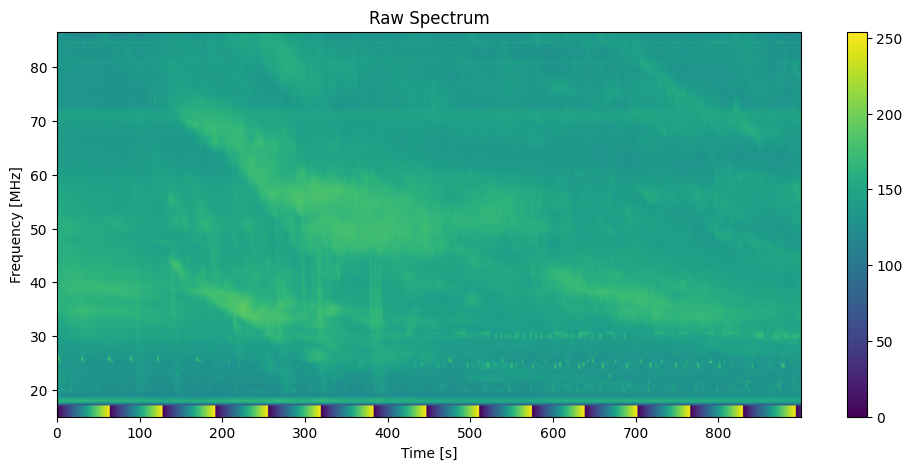

In [26]:
fig, ax, im = ecf.plot_raw_spectrum(ds, title="Raw Spectrum", figsize=(12, 5))
plt.show()

### Background Subtracted (Before Clipping)

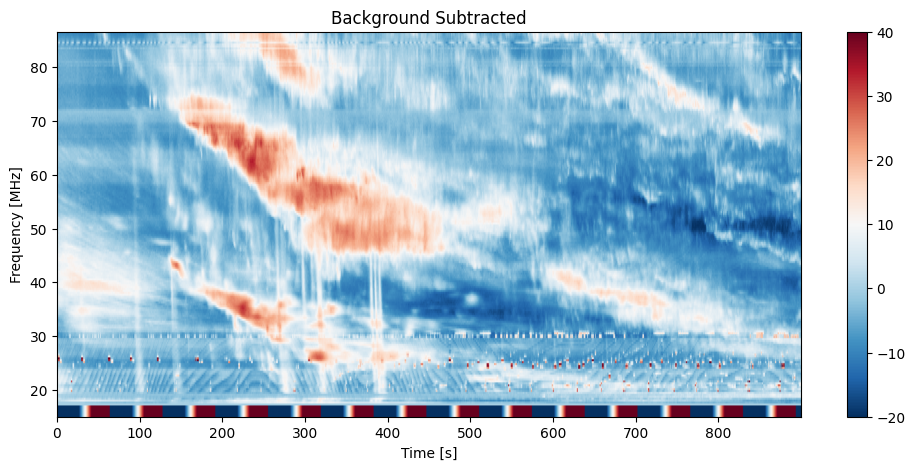

In [27]:
fig, ax, im = ecf.plot_background_subtracted(
    ds,
    title="Background Subtracted",
    vmin=-20, vmax=40,
    cmap="RdBu_r",
    figsize=(12, 5)
)
plt.show()

### Customizable Parameters

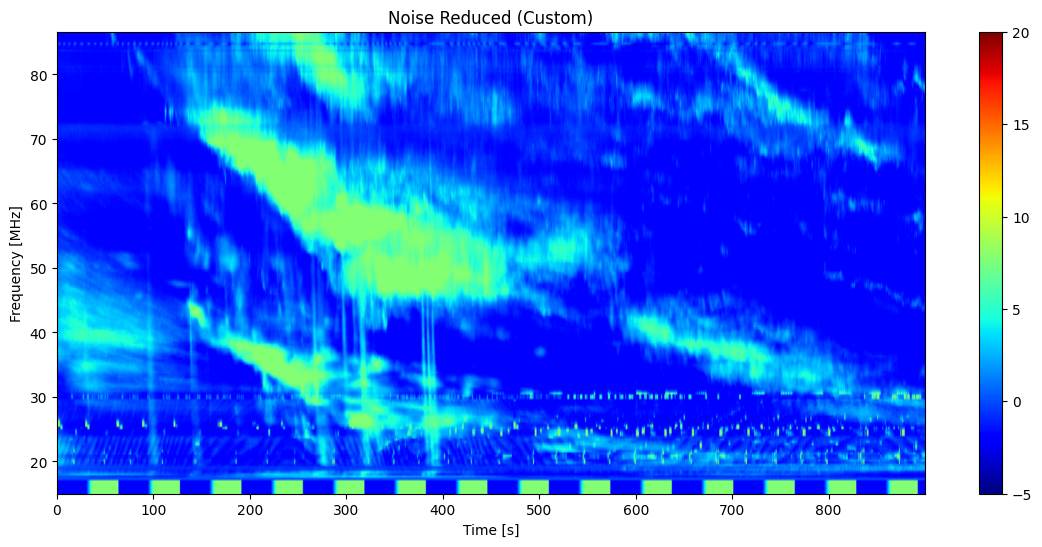

In [30]:
# Plot with custom vmin, vmax, colormap, and figure size
ds_reduced = ecf.noise_reduce_mean_clip(ds)

fig, ax, im = ecf.plot_dynamic_spectrum(
    ds_reduced,
    title="Noise Reduced (Custom)",
    vmin=-5,
    vmax=20,
    cmap="jet",
    figsize=(14, 6),
    interpolation="bilinear"  # matplotlib imshow kwarg
)
plt.show()

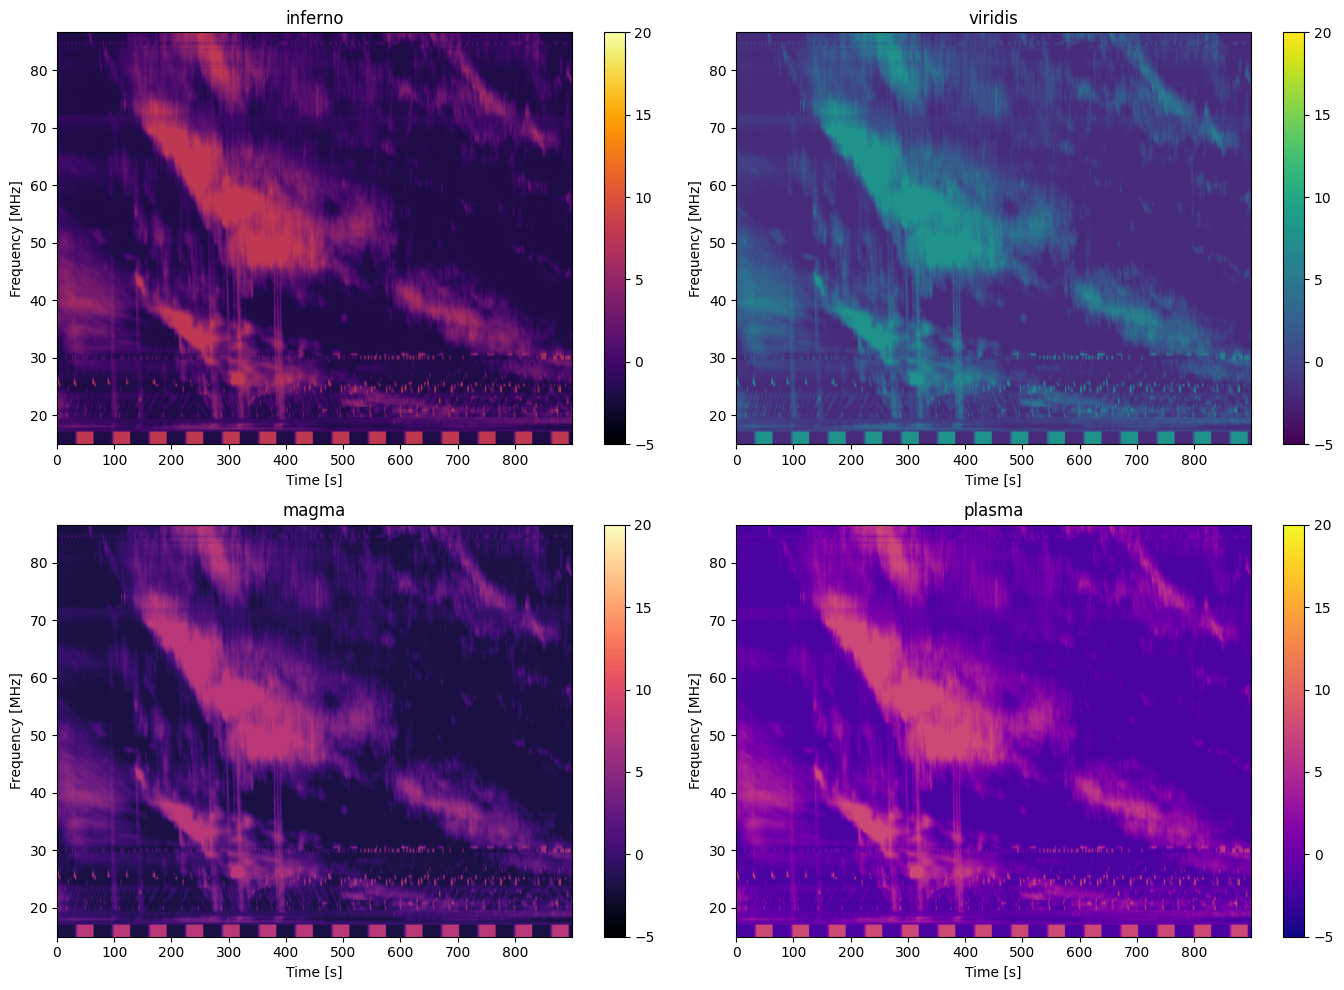

In [31]:
# Compare different colormaps
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, cmap in zip(axes.flat, ["inferno", "viridis", "magma", "plasma"]):
    ecf.plot_dynamic_spectrum(ds_reduced, ax=ax, title=cmap, cmap=cmap, vmin=-5, vmax=20)

plt.tight_layout()
plt.show()

### Time Axis Formats

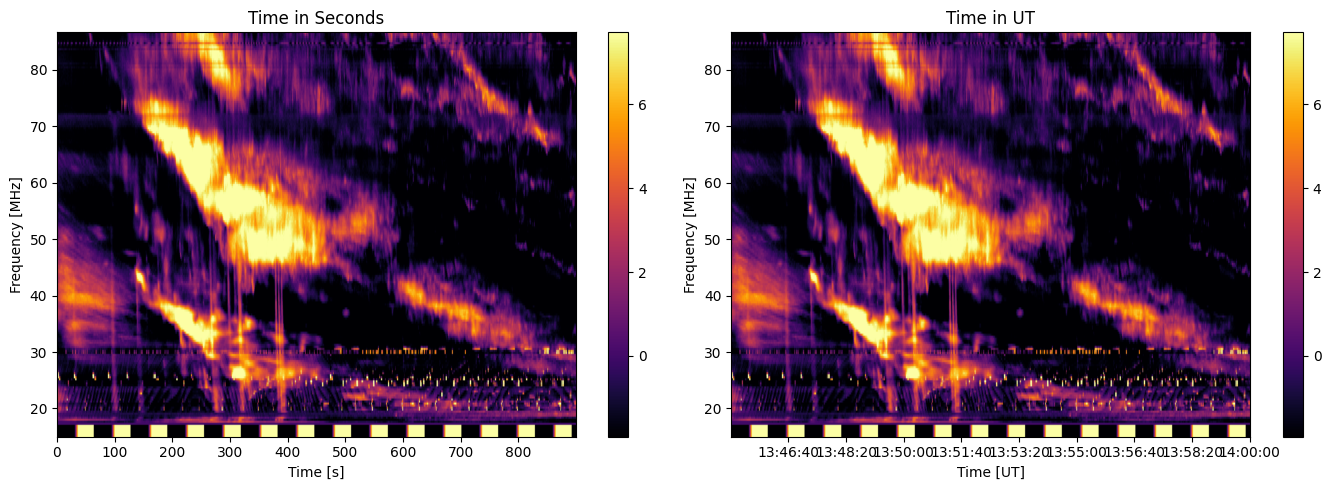

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ecf.plot_dynamic_spectrum(ds_reduced, ax=axes[0], title="Time in Seconds", time_format="seconds")
ecf.plot_dynamic_spectrum(ds_reduced, ax=axes[1], title="Time in UT", time_format="ut")

plt.tight_layout()
plt.show()

---

## 7. Time Axis Conversion

The `TimeAxisConverter` class converts between elapsed seconds and UT time.

In [33]:
# Create from DynamicSpectrum
converter = ecf.TimeAxisConverter.from_dynamic_spectrum(ds)

print(f"Observation started at: {converter.seconds_to_ut(0)}")

Observation started at: 13:45:01


In [34]:
# Convert seconds to UT
for t in [0, 60, 300, 600, 900]:
    print(f"{t:4d} s -> {converter.seconds_to_ut(t)}")

   0 s -> 13:45:01
  60 s -> 13:46:01
 300 s -> 13:50:01
 600 s -> 13:55:01
 900 s -> 14:00:01


In [35]:
# Convert UT to seconds
for ut in ["12:00:00", "12:05:00", "12:10:00", "12:15:00"]:
    print(f"{ut} -> {converter.ut_to_seconds(ut):.0f} s")

12:00:00 -> -6301 s
12:05:00 -> -6001 s
12:10:00 -> -5701 s
12:15:00 -> -5401 s


In [36]:
# Create manually
manual = ecf.TimeAxisConverter(ut_start_sec=43200.0)  # 12:00:00
print(f"1 hour later: {manual.seconds_to_ut(3600)}")

1 hour later: 13:00:00


---

## 8. Complete Workflow

End-to-end example: download, process, crop, and plot solar radio data.

Loaded: Arecibo-Observatory - 20220302


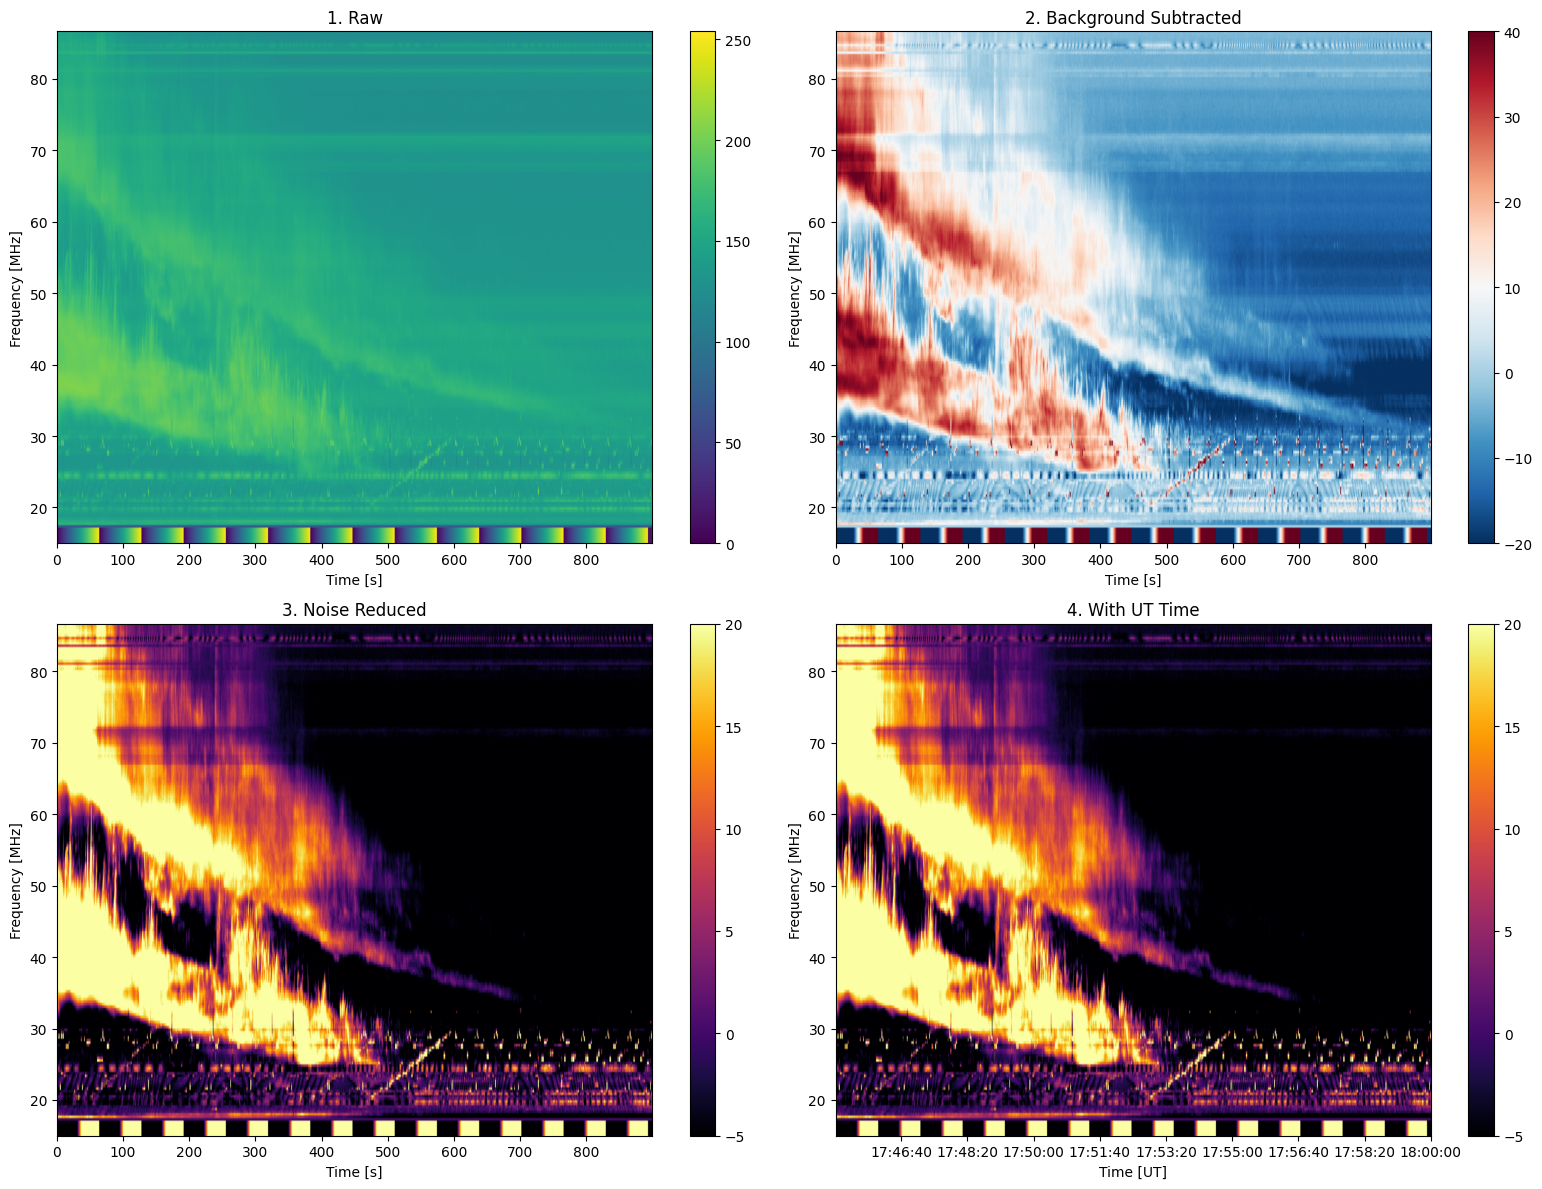


Saved to 'complete_workflow.png'


In [38]:
# 1. Load data (or download with ecf.download_files)
ds = ecf.read_fits("/Users/saan/Desktop/ecallisto-fits/ecallisto-fits/data/Arecibo-Observatory_20220302_174500_62.fit.gz")
print(f"Loaded: {ds.meta.get('station')} - {ds.meta.get('date')}")

# 2. Optional: Crop to region of interest
# ds = ecf.crop(ds, freq_range=(100, 400), time_range=(0, 600))

# 3. Process
ds_reduced = ecf.noise_reduce_mean_clip(ds, clip_low=-5, clip_high=20, scale=None)

# 4. Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ecf.plot_raw_spectrum(ds, ax=axes[0, 0], title="1. Raw")
ecf.plot_background_subtracted(ds, ax=axes[0, 1], title="2. Background Subtracted", vmin=-20, vmax=40)
ecf.plot_dynamic_spectrum(ds_reduced, ax=axes[1, 0], title="3. Noise Reduced")
ecf.plot_dynamic_spectrum(ds_reduced, ax=axes[1, 1], title="4. With UT Time", time_format="ut")

plt.tight_layout()
plt.savefig("complete_workflow.png", dpi=150)
plt.show()

print("\nSaved to 'complete_workflow.png'")

---

## Summary: API Reference

| Category | Function | Description |
|----------|----------|-------------|
| **I/O** | `read_fits(path)` | Load FITS file |
| | `parse_callisto_filename(path)` | Parse filename metadata |
| **Download** | `list_remote_fits(day, hour, station)` | List available files |
| | `download_files(items, out_dir)` | Download files |
| **Processing** | `background_subtract(ds)` | Mean subtraction only |
| | `noise_reduce_mean_clip(ds, ...)` | Full noise reduction |
| **Cropping** | `crop_frequency(ds, min, max)` | Crop frequency range |
| | `crop_time(ds, min, max)` | Crop time range |
| | `crop(ds, freq_range, time_range)` | Crop both axes |
| | `slice_by_index(ds, freq_slice, time_slice)` | Slice by index |
| **Combining** | `can_combine_time(paths)` | Check time compatibility |
| | `combine_time(paths)` | Concatenate along time |
| | `can_combine_frequency(p1, p2)` | Check frequency compatibility |
| | `combine_frequency(p1, p2)` | Stack along frequency |
| **Plotting** | `plot_raw_spectrum(ds, ...)` | Plot raw data |
| | `plot_background_subtracted(ds, ...)` | Plot after background subtraction |
| | `plot_dynamic_spectrum(ds, ...)` | Main plotting function |
| **Time** | `TimeAxisConverter` | Seconds ↔ UT conversion |